In [1]:
from modules.base import *

#### 간단한 개인화 처리
- 아래 2가지 기반으로 답변수행

    - 사용자 개인정보

    - 대화 요약

---

In [2]:
LIMIT_LENGTH = 12 # 대화기록이 특정길이 넘어갈경우 일부삭제

In [3]:
prompt_config = ConfigDict()

prompt_config.decide_personal_prompt = """현재 사용자 요청문에서 사용자의 개인정보가 있는지 판단하세요. 
예를들어 개인정보는 이름, 위치, 관심사, 취미, 직업, 전공, 가족관계 등이 있습니다.
무조건 사용자가 직접적으로 언급한 사실적인 정보만 고려합니다. 추측이나 추론을 하지 마세요.
답변은 무조건 YES 또는 NO로 출력하세요."""

prompt_config.answer_prompt = """당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
{memory}

[이전 대화요약]:
{summary}"""

prompt_config.create_memory_prompt ="""당신은 사용자의 응답을 개인화하기 위해 사용자에 대한 정보를 수집하고 있습니다.

[현재 사용자 정보]
{memory}

지침:
1. 아래의 채팅 기록을 주의 깊게 검토하세요.
2. 사용자에 대한 새로운 정보를 식별하세요. 예를 들면:
   - 개인 정보 (이름, 위치 등)
   - 선호 사항 (좋아하는 것, 싫어하는 것 등)
   - 관심사와 취미
   - 과거 경험
   - 목표나 미래 계획   
   - 질문 유형
   - 답변 선호 사항
3. 새로운 정보를 기존 메모리와 병합하세요.
4. 메모리는 명확한 불릿 리스트 형식으로 작성하세요.
5. 새로운 정보가 기존 메모리와 충돌할 경우, 가장 최근 정보를 유지하세요.
6. 만약 새로운 정보가 없다면 [현재 사용자 정보] 내용을 그대로 출력하세요.
7. 기존 정보를 유지할경우 [현재 사용자 정보] 내용을 그대로 출력하세요.

기억하세요: 사용자가 직접적으로 언급한 사실적인 정보만 포함해야 합니다. 추측이나 추론을 하지 마세요.

아래의 채팅 기록을 바탕으로 사용자 정보를 업데이트하세요:

출력 양식은 반드시 아래를 따르세요.

- 정보 종류 : 정보 내용
- 정보 종류 : 정보 내용
...
"""

prompt_config.summary_prompt = """위 내용들은 사용자와 챗봇의 대화 내용입니다. 사용자와 챗봇이 어떤 대화를 주고 받았는지 내용을 요약해보세요.

지침:
1. 이름, 학업, 취미, 음식, 인적사항 등 사용자의 성향 및 특징을 파악할 수 있는 정보는 요약할 필요없습니다.
2. 개인정보에 대한 대화만 있을 경우 요약하지 않아도 됩니다.
3. 요약할 내용이 없을 경우 빈 문자열을 출력하세요.

출력 양식은 반드시 아래를 따르세요.

- 사용자는 **를 요청했고, 챗봇 답변은 ** 입니다.
- 사용자는 **를 요청했고, 챗봇 답변은 ** 입니다.
...
"""
prompt_config.summary_update_prompt = """위 내용들은 사용자와 챗봇의 대화 내용입니다. 사용자와 챗봇이 어떤 대화를 주고 받았는지 내용을 요약해보세요.

[이전 대화요약]
{summary}

지침:
1. [이전 대화요약]을 주의 깊게 검토하세요.
2. 새로운 정보를 [이전 대화요약]과 병합하세요.
3. 새로운 정보가 [이전 대화요약]과 충돌할 경우, 가장 최근 정보를 유지하세요.
4. 만약 새로운 정보가 없다면 [이전 대화요약] 내용을 그대로 출력하세요.

출력 양식은 반드시 아래를 따르세요.

- 사용자는 **를 요청했고, 챗봇 답변은 ** 입니다.
- 사용자는 **를 요청했고, 챗봇 답변은 ** 입니다.
...
"""

In [4]:
class State(MessagesState):
    is_personal: str

@trace_function(enable_print=True, only_func_name=True)
def node_decide_personal(state: State):
    """
        Des:
            개인정보 여부가 있는지 판단하는 노드
    """
    query = state["messages"][-1].content
    prompt = [SystemMessage(content=prompt_config.decide_personal_prompt)] + [HumanMessage(content=query)]
    return {"is_personal":[llm.invoke(prompt)][0].content.upper()}

@trace_function(enable_print=True, only_func_name=True)
def node_write_memory(state: State, 
                       config: RunnableConfig, 
                       store: BaseStore):
    """
        Des:
            사용자 메시지를 인식하고, 개인정보/선호도/검색결과 등을 저장하는 노드
    """
    query = state["messages"][-1].content
    namespace = ("memories", config["configurable"]["user_id"])
    if state.get("is_personal") == "YES":
        personal_memory = get_memory(namespace=namespace, 
                                      key="personal_info", 
                                      store=store)
        system_message = prompt_config.create_memory_prompt.format(memory=personal_memory)
        memory_prompt = [SystemMessage(content=system_message)] + [HumanMessage(content=query)]
        response = llm.invoke(memory_prompt)
        store.put(namespace=namespace, 
                  key="personal_info", 
                  value={"memory":response.content})
    
@trace_function(enable_print=True, only_func_name=True)
def node_answer(state: State, 
                config: RunnableConfig,
                store: BaseStore):
    namespace = ("memories", config["configurable"]["user_id"])
    personal_memory = get_memory(namespace=namespace, 
                                 key="personal_info", 
                                 store=store)
    summary = get_memory(namespace=namespace, 
                         key="summary", 
                         store=store)
    
    system_message = prompt_config.answer_prompt.format(memory=personal_memory, 
                                                        summary=summary)
    print(f"{PINK}\n{system_message}\n{RESET}")
    prompt = [SystemMessage(content=system_message)] + state["messages"]
    response = llm.invoke(prompt)
    return {"messages": response}

@trace_function(enable_print=True, only_func_name=True)
def node_write_summary(state: State, 
                       config: RunnableConfig,
                       store: BaseStore):    
    if len(state["messages"]) >= LIMIT_LENGTH:
        print(f"{YELLOW}\n대화 길이가 {LIMIT_LENGTH} 이상 ({LIMIT_LENGTH//2}번 이상 대화 주고받음) 이므로 일부 요약합니다.\n{RESET}")
        namespace = ("memories", config["configurable"]["user_id"])
        summary = get_memory(namespace=namespace, 
                            key="summary", 
                            store=store)
        if summary:
            summary_message = prompt_config.summary_update_prompt.format(summary=summary)
        else:
            summary_message = prompt_config.summary_prompt
        prompt = state["messages"] + [HumanMessage(content=summary_message)]
        response = llm.invoke(prompt)
        store.put(namespace=namespace, 
                key="summary", 
                value={"memory":response.content})

@trace_function(enable_print=True, only_func_name=True)
def node_optimize_memory(state: State):
    """
        Des:
            메모리 최적화 함수
    """
    if len(state["messages"]) > LIMIT_LENGTH:
        delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:LIMIT_LENGTH//2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state["messages"]}
        
@trace_function(enable_print=False, only_func_name=True)
def get_memory(namespace, 
                key,
                store:BaseStore):
    """
        Des:
            현재 저장된 사용자 정보를 가져오는 함수
    """
    existing_memory = store.get(namespace=namespace,
                                key=key)
    return existing_memory.value.get('memory') if existing_memory else ""

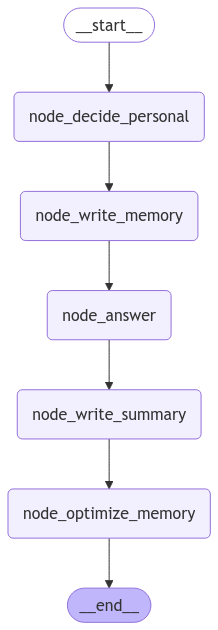

In [5]:
workflow = StateGraph(State)
workflow.add_node("node_decide_personal", node_decide_personal)
workflow.add_node("node_write_memory", node_write_memory)
workflow.add_node("node_answer", node_answer)
workflow.add_node("node_write_summary", node_write_summary)
workflow.add_node("node_optimize_memory", node_optimize_memory)
workflow.add_edge(START, "node_decide_personal")
workflow.add_edge("node_decide_personal", "node_write_memory")
workflow.add_edge("node_write_memory", "node_answer")
workflow.add_edge("node_answer", "node_write_summary")
workflow.add_edge("node_write_summary", "node_optimize_memory")
workflow.add_edge("node_optimize_memory", END)
ShortTermMemory = MemorySaver()
LongTermMemory = InMemoryStore()
graph = workflow.compile(checkpointer=ShortTermMemory,
                         store=LongTermMemory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "first_chat", 
                           "user_id": "changwoo"}}

In [7]:
graph.invoke({"messages":"안녕 나는 창우라고해"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})],
 'is_personal': 'YES'}

In [8]:
graph.invoke({"messages":"나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어."}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [9]:
graph.invoke({"messages":"내 전공은 인공지능이고, 요즘 LLM 분야에 관심이 많아."}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [10]:
graph.invoke({"messages":"내 취미는 헬스장에서 운동하는거야"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [11]:
graph.invoke({"messages":"이순신 장군에 대해 간단히 알려줄래?"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [12]:
graph.invoke({"messages":"2차전지가 뭐임?"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:



🚀 Passing Through [node_write_summary] ..

대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 일부 요약합니다.


🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='안녕 나는 창우라고해', additional_kwargs={}, response_metadata={}, id='012dc57f-1bd5-4f6c-a3e2-427091ee8891'),
  AIMessage(content='안녕하세요, 창우님! 만나서 반갑습니다. 오늘 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 68, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b7d65f1a5b', 'finish_reason': 'stop', 'logprobs': None}, id='run-972e103d-eca9-4976-b8e2-22639b66a0f9-0', usage_metadata={'input_tokens': 68, 'output_tokens': 22, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='나는 올해 30살이고, 현재 부산대학교에서 박사과정을 하고있어.', additional_kwargs={}, response_metadata={

In [13]:
graph.invoke({"messages":"대한민국에 대해 알려줘 간단히"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:
- 사용자는 이순신 장군에 대해 요청했고, 챗봇 답변은 그의 업적과 임진왜란 당시 활약에 대한 설명입니다.
- 사용자는 2차 전지에 대해 요청했고, 챗봇 답변은 2차 전지의 정의와 예, 활용 분야에 대한 설명입니다.


🚀 Passing Through [node_write_summary] ..

대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 일부 요약합니다.


🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='c04eaa7c-5908-4a33-9b88-3ae932c4954d'),
  AIMessage(content='운동은 건강에도 좋고 스트레스 해소에도 도움이 되죠! 헬스장에서 어떤 운동을 주로 하시나요? 특정 목표를 위해 운동 중이신가요, 아니면 그냥 즐기기 위해 하시나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 309, 'total_tokens': 361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason': 'stop', 'logprobs': None}, id='run-55c92710-ab87-49a5-8f1b-3c6d86cbf030-0', usage_metadata={'input_tokens': 309, 'output_tokens': 52, 'total_tokens': 361, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='이순신 장군에 대해 간단히

In [14]:
graph.invoke({"messages":"대한민국 남자들은 군대 가야해?"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:
- 사용자는 이순신 장군에 대해 요청했고, 챗봇 답변은 그의 업적과 임진왜란 당시 활약에 대한 설명입니다.
- 사용자는 2차 전지에 대해 요청했고, 챗봇 답변은 2차 전지의 정의와 예, 활용 분야에 대한 설명입니다.
- 사용자는 대한민국에 대해 요청했고, 챗봇 답변은 대한민국의 위치, 인구, 경제, 문화 및 정치 체제에 대한 간단한 설명입니다.


🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='c04eaa7c-5908-4a33-9b88-3ae932c4954d'),
  AIMessage(content='운동은 건강에도 좋고 스트레스 해소에도 도움이 되죠! 헬스장에서 어떤 운동을 주로 하시나요? 특정 목표를 위해 운동 중이신가요, 아니면 그냥 즐기기 위해 하시나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 309, 'total_tokens': 361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason': 'stop', 'logprobs': None}, id='run-55c92710-ab87-49a5-8f1b-3c6d86cbf030-0', usage_metadata={'input_tokens': 309, 'output_tokens': 52, 'total_tokens': 361, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='이순신 장군에 대해 간단히

In [15]:
graph.invoke({"messages":"지금 미국대통령 누구임?"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:
- 사용자는 이순신 장군에 대해 요청했고, 챗봇 답변은 그의 업적과 임진왜란 당시 활약에 대한 설명입니다.
- 사용자는 2차 전지에 대해 요청했고, 챗봇 답변은 2차 전지의 정의와 예, 활용 분야에 대한 설명입니다.
- 사용자는 대한민국에 대해 요청했고, 챗봇 답변은 대한민국의 위치, 인구, 경제, 문화 및 정치 체제에 대한 간단한 설명입니다.


🚀 Passing Through [node_write_summary] ..

대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 일부 요약합니다.


🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='내 취미는 헬스장에서 운동하는거야', additional_kwargs={}, response_metadata={}, id='c04eaa7c-5908-4a33-9b88-3ae932c4954d'),
  AIMessage(content='운동은 건강에도 좋고 스트레스 해소에도 도움이 되죠! 헬스장에서 어떤 운동을 주로 하시나요? 특정 목표를 위해 운동 중이신가요, 아니면 그냥 즐기기 위해 하시나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 309, 'total_tokens': 361, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason': 'stop', 'logprobs': None}, id='run-55c92710-ab87-49a5-8f1b-3c6d86cbf030-0', usage_metadata={'input_tokens': 309, 'output_tokens': 52, 'total_tokens': 361, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='이순신 장군에 대해 간단히

In [16]:
graph.invoke({"messages":"한국 대통령에 대해도 알려줘"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:
- 사용자는 이순신 장군에 대해 요청했고, 챗봇 답변은 그의 업적과 임진왜란 당시 활약에 대한 설명입니다.
- 사용자는 2차 전지에 대해 요청했고, 챗봇 답변은 2차 전지의 정의와 예, 활용 분야에 대한 설명입니다.
- 사용자는 대한민국에 대해 요청했고, 챗봇 답변은 대한민국의 위치, 인구, 경제, 문화 및 정치 체제에 대한 간단한 설명입니다.
- 사용자는 대한민국 남자들의 군 복무 여부에 대해 요청했고, 챗봇 답변은 대한민국 남성의 병역 의무와 복무 기간에 대한 설명입니다.
- 사용자는 현재 미국 대통령에 대해 요청했고, 챗봇 답변은 2023년 기준 조 바이든이 대통령이라는 설명입니다.


🚀 Passing Through [node_write_summary] ..

대화 길이가 12 이상 (6번 이상 대화 주고받음) 이므로 일부 요약합니다.


🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='대한민국에 대해 알려줘 간단히', additional_kwargs={}, response_metadata={}, id='fcbe3440-59c7-44b2-bfb5-f588c5cb876d'),
  AIMessage(content='대한민국은 동아시아의 한반도 남부에 위치한 나라로, 서울이 수도입니다. 인구는 약 5천만 명이며, 공용어는 한국어입니다. 대한민국은 1948년에 정부가 수립되었으며, 이후 급속한 경제 성장을 이루어 "한강의 기적"이라고 불리는 발전을 이뤘습니다. \n\n한국은 전 세계적으로 IT와 전자 제품, 자동차, 조선업에서 강력한 경쟁력을 보유하고 있으며, 삼성, LG, 현대와 같은 글로벌 기업들이 본사를 두고 있습니다. 문화적으로는 K-팝, 드라마, 영화 등 한류가 전 세계적으로 인기를 끌고 있습니다. \n\n정치 체제는 민주공화국으로, 대통령제를 채택하고 있으며, 국민의 높은 교육 수준과 활발한 시민 참여가 특징입니다. 한국은 풍부한 역사와 문화를 가지고 있으며, 현대적이면서도 전통을 중시하는 사회입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 213, 'prompt_tokens': 793, 'total_tokens': 1006, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason':

In [17]:
graph.invoke({"messages":"김치에 대해 알려줄래? 어떻게만듦? 간단히"}, config=config)


🚀 Passing Through [node_decide_personal] ..

🚀 Passing Through [node_write_memory] ..

🚀 Passing Through [node_answer] ..

당신은 [사용자 정보]와 [이전 대화요약]을 통해 답변하는 유용한 챗봇입니다.
[사용자 정보]:
- 이름: 창우
- 나이: 30살
- 교육: 부산대학교 박사과정
- 전공: 인공지능
- 관심사: LLM 분야
- 취미: 헬스장에서 운동하기

[이전 대화요약]:
- 사용자는 이순신 장군에 대해 요청했고, 챗봇 답변은 그의 업적과 임진왜란 당시 활약에 대한 설명입니다.
- 사용자는 2차 전지에 대해 요청했고, 챗봇 답변은 2차 전지의 정의와 예, 활용 분야에 대한 설명입니다.
- 사용자는 대한민국에 대해 요청했고, 챗봇 답변은 대한민국의 위치, 인구, 경제, 문화 및 정치 체제에 대한 간단한 설명입니다.
- 사용자는 대한민국 남자들의 군 복무 여부에 대해 요청했고, 챗봇 답변은 대한민국 남성의 병역 의무와 복무 기간에 대한 설명입니다.
- 사용자는 현재 미국 대통령에 대해 요청했고, 챗봇 답변은 2023년 기준 조 바이든이 대통령이라는 설명입니다.
- 사용자는 한국 대통령에 대해 요청했고, 챗봇 답변은 2023년 기준 윤석열이 대통령이라는 설명입니다.


🚀 Passing Through [node_write_summary] ..

🚀 Passing Through [node_optimize_memory] ..


{'messages': [HumanMessage(content='대한민국에 대해 알려줘 간단히', additional_kwargs={}, response_metadata={}, id='fcbe3440-59c7-44b2-bfb5-f588c5cb876d'),
  AIMessage(content='대한민국은 동아시아의 한반도 남부에 위치한 나라로, 서울이 수도입니다. 인구는 약 5천만 명이며, 공용어는 한국어입니다. 대한민국은 1948년에 정부가 수립되었으며, 이후 급속한 경제 성장을 이루어 "한강의 기적"이라고 불리는 발전을 이뤘습니다. \n\n한국은 전 세계적으로 IT와 전자 제품, 자동차, 조선업에서 강력한 경쟁력을 보유하고 있으며, 삼성, LG, 현대와 같은 글로벌 기업들이 본사를 두고 있습니다. 문화적으로는 K-팝, 드라마, 영화 등 한류가 전 세계적으로 인기를 끌고 있습니다. \n\n정치 체제는 민주공화국으로, 대통령제를 채택하고 있으며, 국민의 높은 교육 수준과 활발한 시민 참여가 특징입니다. 한국은 풍부한 역사와 문화를 가지고 있으며, 현대적이면서도 전통을 중시하는 사회입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 213, 'prompt_tokens': 793, 'total_tokens': 1006, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_703d4ff298', 'finish_reason':